In [1]:
#install.packages('e1071')
library(ggplot2)
library(dplyr)
library(caTools) # Prediction: Splitting Data
library(ROCR) # Prediction: ROC Curve
library(caret) # Prediction: k-Fold Cross Validatio


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: gplots

Attaching package: ‘gplots’

The following object is masked from ‘package:stats’:

    lowess

Loading required package: lattice


# 2 ways of reading Rda data 

In [70]:
env = new.env()
flowers = load('flowers.Rda', env)[1]

In [71]:
flower_df = env[[flowers]]

In [25]:
flowers = load('flowers.Rda')
flowers_df2 = get(flowers)

In [72]:
head(flower_df)

petal.length,petal.width,type,stem.length
4.433944,1.854428,1,59.5
4.447289,2.890259,1,55.2
4.397470,2.124019,1,59.3
6.002785,3.308436,1,59.0
5.166973,2.481583,1,69.6
4.528409,1.913785,1,64.6


In [73]:
str(flower_df)

'data.frame':	460 obs. of  4 variables:
 $ petal.length: num  4.43 4.45 4.4 6 5.17 ...
 $ petal.width : num  1.85 2.89 2.12 3.31 2.48 ...
 $ type        : num  1 1 1 1 1 1 1 1 1 1 ...
 $ stem.length : num  59.5 55.2 59.3 59 69.6 64.6 60 57.8 77.1 63.1 ...


In [74]:
flower_df= mutate(flower_df,type = factor(type,levels=c(0,1), labels=c("pink","yellow")))
colnames(flower_df)[colnames(flower_df) == "type"] = "lily.type"
head(flower_df)

petal.length,petal.width,lily.type,stem.length
4.433944,1.854428,yellow,59.5
4.447289,2.890259,yellow,55.2
4.397470,2.124019,yellow,59.3
6.002785,3.308436,yellow,59.0
5.166973,2.481583,yellow,69.6
4.528409,1.913785,yellow,64.6


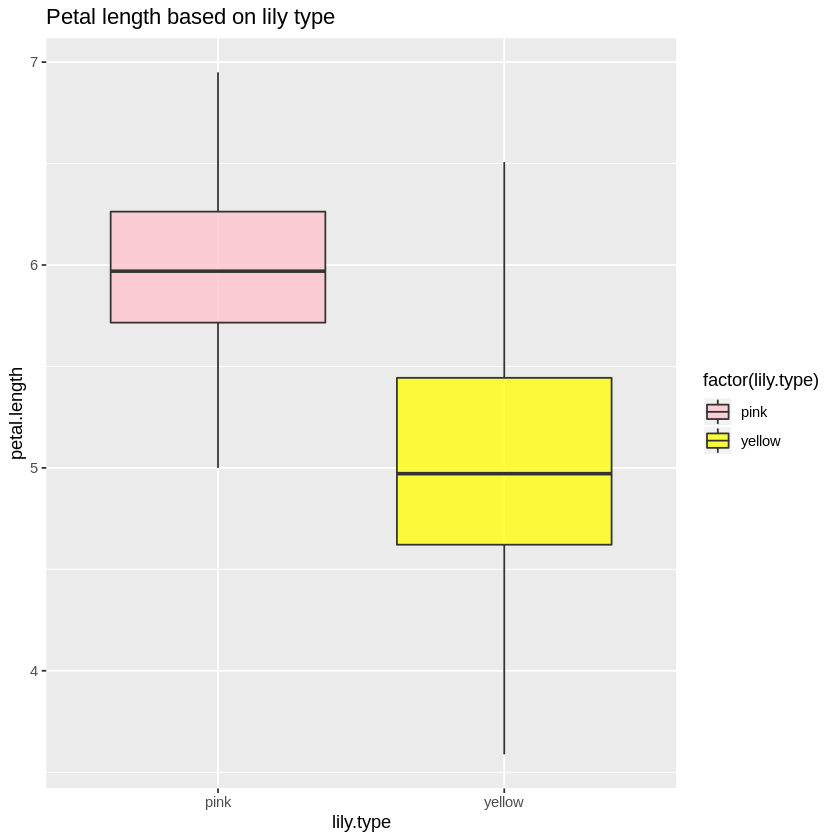

In [80]:
ggplot(flower_df,aes(lily.type,petal.length)) +                                                  
  geom_boxplot(aes(fill=factor(lily.type)),alpha=0.75) +
  ggtitle("Petal length based on lily type") +
    scale_fill_manual(values=c("pink", "yellow"))


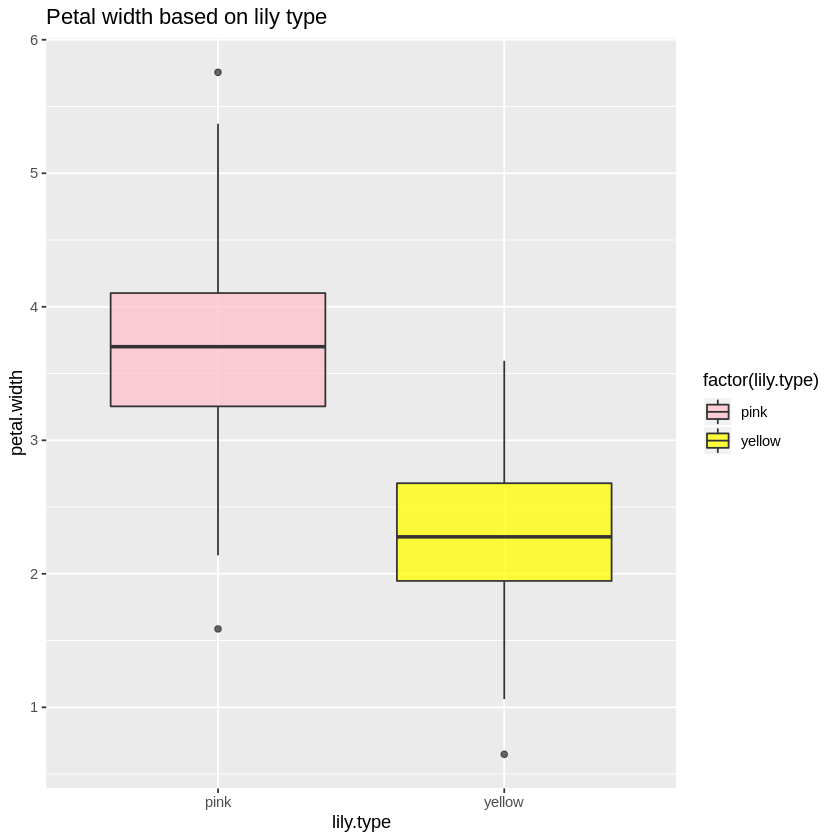

In [78]:
ggplot(flower_df,aes(lily.type,petal.width)) +                                                  
  geom_boxplot(aes(fill=factor(lily.type)),alpha=0.75) +
  ggtitle("Petal width based on lily type") +
    scale_fill_manual(values=c("pink", "yellow"))

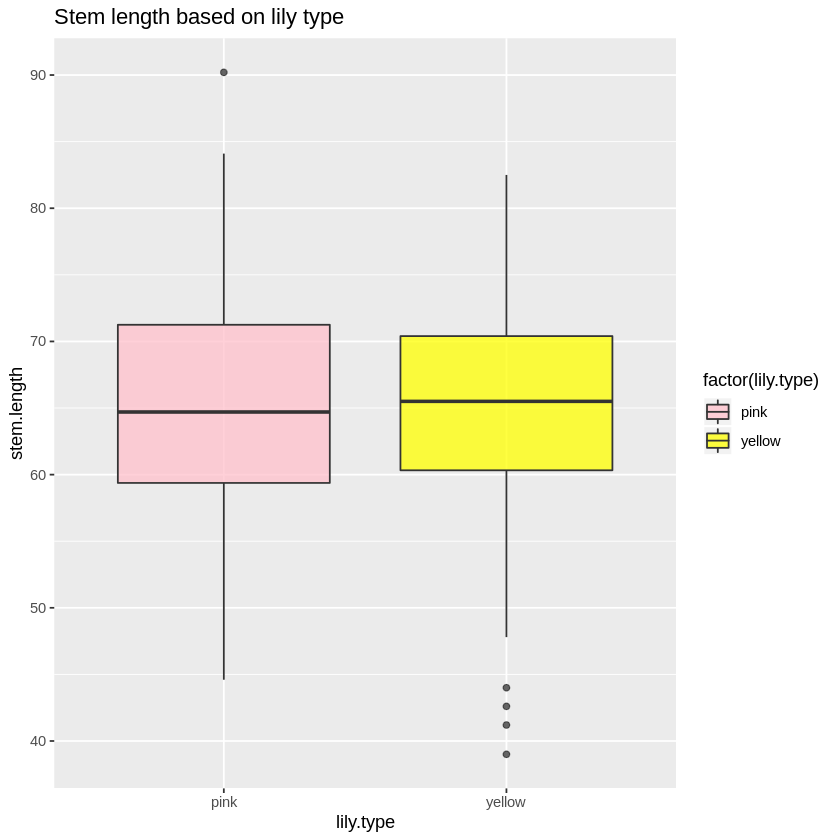

In [79]:
ggplot(flower_df,aes(lily.type,stem.length)) +                                                  
  geom_boxplot(aes(fill=factor(lily.type)),alpha=0.75) +
  ggtitle("Stem length based on lily type") +
    scale_fill_manual(values=c("pink", "yellow"))

### Petal Length and Width seem to be suitable variables. No point using stem length

In [83]:
t.test(stem.length~ lily.type, mu=0, alt="two.sided", conf=0.95, data=flower_df)


	Welch Two Sample t-test

data:  stem.length by lily.type
t = -0.57529, df = 455.46, p-value = 0.5654
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -1.985274  1.086144
sample estimates:
  mean in group pink mean in group yellow 
            64.72174             65.17130 


### no obviously we cant reject the 0 hypothesis

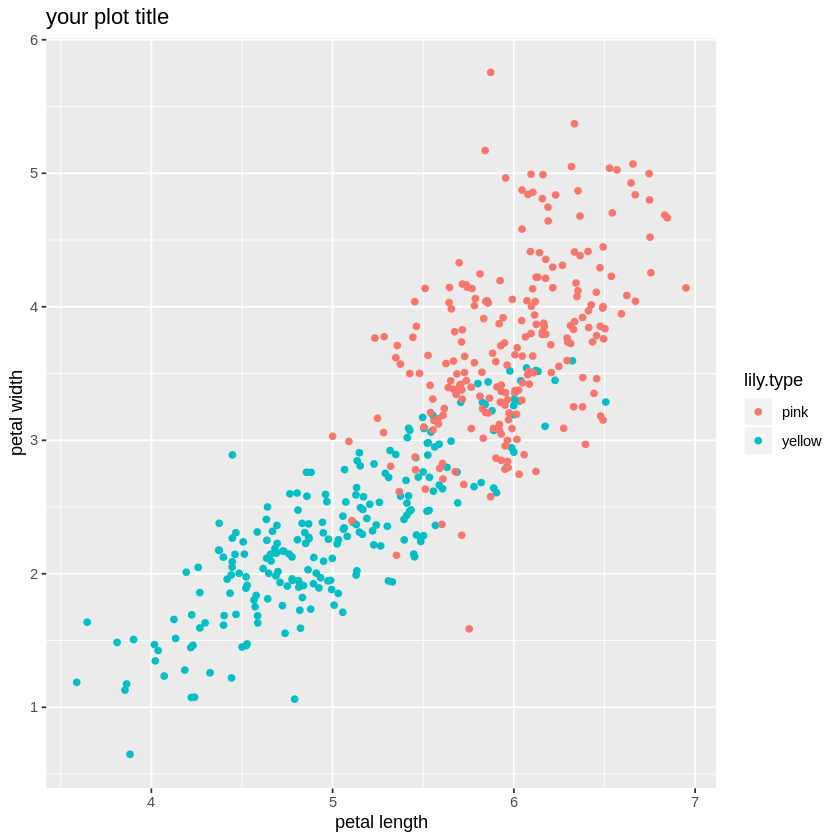

In [86]:
ggplot(data = flower_df) + 
    geom_point(mapping = aes(x = petal.length, y=petal.width, color = lily.type))+
    labs(y = "petal width", x="petal length") +
    ggtitle("your plot title")

In [87]:
set.seed(123)
split = sample.split(flower_df$lily.type, SplitRatio=0.5)


In [108]:
train = subset(flower_df, split==TRUE)
test = subset(flower_df, split==FALSE)

#sample split not just randomly splots - it also preserves the RATIOS of different labels. 
#so its better to use sample.split like we learned, instead of random sampling
head(test)

,petal.length,petal.width,lily.type,stem.length
2,4.447289,2.890259,yellow,55.2
4,6.002785,3.308436,yellow,59.0
5,5.166973,2.481583,yellow,69.6
7,5.393799,2.407343,yellow,60.0
8,5.136093,2.846416,yellow,57.8
9,5.563392,2.950102,yellow,77.1


In [173]:
# use gml function here instead of caret::train() 
classifier_logreg = glm(lily.type ~ petal.length + petal.width, family = binomial(link='logit'), data = train)
summary(classifier_logreg)


Call:
glm(formula = lily.type ~ petal.length + petal.width, family = binomial(link = "logit"), 
    data = train)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-2.34923  -0.39749  -0.01169   0.29942   2.26431  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept)   19.0389     3.4653   5.494 3.93e-08 ***
petal.length  -2.2190     0.7368  -3.012   0.0026 ** 
petal.width   -2.2541     0.5572  -4.046 5.22e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 318.85  on 229  degrees of freedom
Residual deviance: 133.39  on 227  degrees of freedom
AIC: 139.39

Number of Fisher Scoring iterations: 6


In [138]:
# Predicting the training set results
predicted_probs_train = predict(classifier_logreg, type = 'response', newdata = train)

y_pred_train = ifelse(predicted_probs_train > 0.5, 'yellow', 'pink')



In [139]:
error <- mean(train$lily.type != y_pred_train  ) # Misclassification error
paste('Accuracy',round(1-error,10))

[1] "Accuracy 0.8695652174"

In [140]:
table(train$lily.type, y_pred_train)

        y_pred_train
         pink yellow
  pink    100     15
  yellow   15    100

In [145]:
# Predicting the test set results
predicted_probs_test = predict(classifier_logreg, type = 'response', newdata = test)

y_pred_test = ifelse(predicted_probs_test > 0.5, 'yellow', 'pink')


In [146]:
error = mean(test$lily.type != y_pred_test  ) # Misclassification error
paste('Accuracy',round(1-error,10))

[1] "Accuracy 0.9086956522"

In [148]:
table(test$lily.type, y_pred_test)

        y_pred_test
         pink yellow
  pink    110      5
  yellow   16     99

In [149]:
test$predicted_type = y_pred_test

In [150]:
head(test)

,petal.length,petal.width,lily.type,stem.length,predicted_type
2,4.447289,2.890259,yellow,55.2,yellow
4,6.002785,3.308436,yellow,59.0,pink
5,5.166973,2.481583,yellow,69.6,yellow
7,5.393799,2.407343,yellow,60.0,yellow
8,5.136093,2.846416,yellow,57.8,yellow
9,5.563392,2.950102,yellow,77.1,yellow


# KNN

In [154]:
#this is a weird question...they must have learned KNN a different way in class. no idea why it has to be in 
# different dataframes but what the heck, let's do it


df_train_x = train[,1:2]
head(df_train_x)

,petal.length,petal.width
1,4.433944,1.854428
3,4.397470,2.124019
6,4.528409,1.913785
10,4.831523,2.377737
12,5.447378,2.147435
15,5.879141,3.221662


In [157]:
df_train_y = train$lily.type
head(df_train_y)

[1] yellow yellow yellow yellow yellow yellow
Levels: pink yellow

In [158]:

df_test_x = test[,1:2]
head(df_test_x)

,petal.length,petal.width
2,4.447289,2.890259
4,6.002785,3.308436
5,5.166973,2.481583
7,5.393799,2.407343
8,5.136093,2.846416
9,5.563392,2.950102


In [163]:
model_knn = train(lily.type ~ petal.length + petal.width, data=train, method="knn", tuneGrid = expand.grid(k = 1:10)) # can also use tunelength
    #trControl=train.control)

In [164]:
print(model_knn)

k-Nearest Neighbors 

230 samples
  2 predictor
  2 classes: 'pink', 'yellow' 

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 230, 230, 230, 230, 230, 230, ... 
Resampling results across tuning parameters:

  k   Accuracy   Kappa    
   1  0.8101645  0.6194767
   2  0.8127690  0.6242223
   3  0.8175450  0.6331514
   4  0.8159669  0.6301984
   5  0.8132377  0.6246702
   6  0.8167882  0.6319551
   7  0.8210304  0.6408723
   8  0.8228771  0.6442121
   9  0.8272062  0.6532814
  10  0.8272291  0.6529374

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was k = 10.


### I assume that this is not exactly what the question asks. I assume they used some other R library/function for KNN where you can specify K. caret::train() uses the model with the best K. In this case it was with K=10 because we are only checking up to K 10. If we tune the grid 1:20 and check up to 20 K, train selects the model with K=19

In [168]:
y_pred_test_knn = predict(model_knn, newdata = test)

In [169]:
table(test$lily.type, y_pred_test_knn)

        y_pred_test_knn
         pink yellow
  pink    106      9
  yellow   24     91

In [170]:
error = mean(test$lily.type != y_pred_test_knn) # Misclassification error
paste('Accuracy',round(1-error,10))

[1] "Accuracy 0.8565217391"

In the exam you might be asked to check for different k values - as I said, then you retune the grid in the train() function. See example below

In [181]:
k_vals = c( 1:10, seq(30,1000,10)) 

[1]    1    2    3    4    5    6    7    8    9   10   30   40   50   60   70
 [16]   80   90  100  110  120  130  140  150  160  170  180  190  200  210  220
 [31]  230  240  250  260  270  280  290  300  310  320  330  340  350  360  370
 [46]  380  390  400  410  420  430  440  450  460  470  480  490  500  510  520
 [61]  530  540  550  560  570  580  590  600  610  620  630  640  650  660  670
 [76]  680  690  700  710  720  730  740  750  760  770  780  790  800  810  820
 [91]  830  840  850  860  870  880  890  900  910  920  930  940  950  960  970
[106]  980  990 1000

In [182]:
# lets use cross validation this time
set.seed(123)
train.control = trainControl(method = "repeatedcv", number =10, repeats=3)

model_knn_2 = train(lily.type ~ petal.length + petal.width, data=train, method="knn", tuneGrid = expand.grid(k = k_vals), # can also use tunelength
    trControl=train.control)

Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 210 exceeds number 208 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 220 exceeds number 208 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 230 exceeds number 208 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 240 exceeds number 208 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 250 exceeds number 208 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 260 exceeds number 208 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 270 exceeds number 208 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 280 exceeds number 

“k = 850 exceeds number 208 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 860 exceeds number 208 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 870 exceeds number 208 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 880 exceeds number 208 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 890 exceeds number 208 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 900 exceeds number 208 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 910 exceeds number 208 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 920 exceeds number 208 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39

“k = 700 exceeds number 208 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 710 exceeds number 208 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 720 exceeds number 208 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 730 exceeds number 208 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 740 exceeds number 208 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 750 exceeds number 208 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 760 exceeds number 208 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 770 exceeds number 208 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39

“k = 550 exceeds number 208 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 560 exceeds number 208 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 570 exceeds number 208 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 580 exceeds number 208 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 590 exceeds number 208 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 600 exceeds number 208 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 610 exceeds number 208 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 620 exceeds number 208 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39

“k = 400 exceeds number 206 of patterns”Warning message in knn3Train(train = structure(c(4.39746964608583, 4.52840894267573, :
“k = 410 exceeds number 206 of patterns”Warning message in knn3Train(train = structure(c(4.39746964608583, 4.52840894267573, :
“k = 420 exceeds number 206 of patterns”Warning message in knn3Train(train = structure(c(4.39746964608583, 4.52840894267573, :
“k = 430 exceeds number 206 of patterns”Warning message in knn3Train(train = structure(c(4.39746964608583, 4.52840894267573, :
“k = 440 exceeds number 206 of patterns”Warning message in knn3Train(train = structure(c(4.39746964608583, 4.52840894267573, :
“k = 450 exceeds number 206 of patterns”Warning message in knn3Train(train = structure(c(4.39746964608583, 4.52840894267573, :
“k = 460 exceeds number 206 of patterns”Warning message in knn3Train(train = structure(c(4.39746964608583, 4.52840894267573, :
“k = 470 exceeds number 206 of patterns”Warning message in knn3Train(train = structure(c(4.39746964608583, 4.52

“k = 250 exceeds number 206 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 260 exceeds number 206 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 270 exceeds number 206 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 280 exceeds number 206 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 290 exceeds number 206 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 300 exceeds number 206 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 310 exceeds number 206 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 320 exceeds number 206 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39

“k = 900 exceeds number 206 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 910 exceeds number 206 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 920 exceeds number 206 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 930 exceeds number 206 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 940 exceeds number 206 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 950 exceeds number 206 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 960 exceeds number 206 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 970 exceeds number 206 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39

“k = 750 exceeds number 206 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 760 exceeds number 206 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 770 exceeds number 206 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 780 exceeds number 206 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 790 exceeds number 206 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 800 exceeds number 206 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 810 exceeds number 206 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 820 exceeds number 206 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39

“k = 600 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 610 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 620 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 630 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 640 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 650 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 660 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 670 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39

“k = 450 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 460 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 470 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 480 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 490 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 500 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 510 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 520 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39

“k = 300 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.52840894267573, :
“k = 310 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.52840894267573, :
“k = 320 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.52840894267573, :
“k = 330 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.52840894267573, :
“k = 340 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.52840894267573, :
“k = 350 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.52840894267573, :
“k = 360 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.52840894267573, :
“k = 370 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.52

“k = 950 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.52840894267573, :
“k = 960 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.52840894267573, :
“k = 970 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.52840894267573, :
“k = 980 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.52840894267573, :
“k = 990 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.52840894267573, :
“k = 1000 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 210 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 220 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.3

“k = 800 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 810 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 820 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 830 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 840 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 850 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 860 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 870 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39

“k = 650 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 660 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 670 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 680 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 690 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 700 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 710 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 720 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39

“k = 500 exceeds number 206 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 510 exceeds number 206 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 520 exceeds number 206 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 530 exceeds number 206 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 540 exceeds number 206 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 550 exceeds number 206 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 560 exceeds number 206 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 570 exceeds number 206 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39

“k = 350 exceeds number 206 of patterns”Warning message in knn3Train(train = structure(c(4.39746964608583, 4.52840894267573, :
“k = 360 exceeds number 206 of patterns”Warning message in knn3Train(train = structure(c(4.39746964608583, 4.52840894267573, :
“k = 370 exceeds number 206 of patterns”Warning message in knn3Train(train = structure(c(4.39746964608583, 4.52840894267573, :
“k = 380 exceeds number 206 of patterns”Warning message in knn3Train(train = structure(c(4.39746964608583, 4.52840894267573, :
“k = 390 exceeds number 206 of patterns”Warning message in knn3Train(train = structure(c(4.39746964608583, 4.52840894267573, :
“k = 400 exceeds number 206 of patterns”Warning message in knn3Train(train = structure(c(4.39746964608583, 4.52840894267573, :
“k = 410 exceeds number 206 of patterns”Warning message in knn3Train(train = structure(c(4.39746964608583, 4.52840894267573, :
“k = 420 exceeds number 206 of patterns”Warning message in knn3Train(train = structure(c(4.39746964608583, 4.52

“k = 1000 exceeds number 206 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 210 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 220 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 230 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 240 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 250 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 260 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 270 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.3

“k = 850 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 860 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 870 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 880 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 890 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 900 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 910 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 920 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39

“k = 700 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 710 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 720 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 730 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 740 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 750 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 760 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 770 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39

“k = 550 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 560 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 570 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 580 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 590 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 600 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 610 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 620 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39

“k = 400 exceeds number 208 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 410 exceeds number 208 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 420 exceeds number 208 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 430 exceeds number 208 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 440 exceeds number 208 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 450 exceeds number 208 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 460 exceeds number 208 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 470 exceeds number 208 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39

“k = 250 exceeds number 208 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.52840894267573, :
“k = 260 exceeds number 208 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.52840894267573, :
“k = 270 exceeds number 208 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.52840894267573, :
“k = 280 exceeds number 208 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.52840894267573, :
“k = 290 exceeds number 208 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.52840894267573, :
“k = 300 exceeds number 208 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.52840894267573, :
“k = 310 exceeds number 208 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.52840894267573, :
“k = 320 exceeds number 208 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.52

“k = 900 exceeds number 208 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.52840894267573, :
“k = 910 exceeds number 208 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.52840894267573, :
“k = 920 exceeds number 208 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.52840894267573, :
“k = 930 exceeds number 208 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.52840894267573, :
“k = 940 exceeds number 208 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.52840894267573, :
“k = 950 exceeds number 208 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.52840894267573, :
“k = 960 exceeds number 208 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.52840894267573, :
“k = 970 exceeds number 208 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.52

“k = 750 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 760 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 770 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 780 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 790 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 800 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 810 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 820 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39

“k = 600 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 610 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 620 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 630 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 640 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 650 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 660 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 670 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39

“k = 450 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 460 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 470 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 480 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 490 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 500 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 510 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 520 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39

“k = 300 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 310 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 320 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 330 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 340 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 350 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 360 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 370 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39

“k = 950 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 960 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 970 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 980 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 990 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 1000 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 210 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 220 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.3

“k = 800 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 810 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 820 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 830 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 840 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 850 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 860 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 870 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39

“k = 650 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 660 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 670 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 680 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 690 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 700 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 710 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 720 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39

“k = 500 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 510 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 520 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 530 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 540 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 550 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 560 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 570 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39

“k = 350 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 360 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 370 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 380 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 390 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 400 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 410 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 420 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39

“k = 1000 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.39746964608583, 4.52840894267573, :
“k = 210 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.39746964608583, 4.52840894267573, :
“k = 220 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.39746964608583, 4.52840894267573, :
“k = 230 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.39746964608583, 4.52840894267573, :
“k = 240 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.39746964608583, 4.52840894267573, :
“k = 250 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.39746964608583, 4.52840894267573, :
“k = 260 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.39746964608583, 4.52840894267573, :
“k = 270 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.39746964608583, 4.5

“k = 850 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.39746964608583, 4.52840894267573, :
“k = 860 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.39746964608583, 4.52840894267573, :
“k = 870 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.39746964608583, 4.52840894267573, :
“k = 880 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.39746964608583, 4.52840894267573, :
“k = 890 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.39746964608583, 4.52840894267573, :
“k = 900 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.39746964608583, 4.52840894267573, :
“k = 910 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.39746964608583, 4.52840894267573, :
“k = 920 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.39746964608583, 4.52

“k = 700 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 710 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 720 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 730 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 740 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 750 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 760 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 770 exceeds number 207 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39

“k = 550 exceeds number 208 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.52840894267573, :
“k = 560 exceeds number 208 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.52840894267573, :
“k = 570 exceeds number 208 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.52840894267573, :
“k = 580 exceeds number 208 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.52840894267573, :
“k = 590 exceeds number 208 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.52840894267573, :
“k = 600 exceeds number 208 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.52840894267573, :
“k = 610 exceeds number 208 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.52840894267573, :
“k = 620 exceeds number 208 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.52

“k = 400 exceeds number 206 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 410 exceeds number 206 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 420 exceeds number 206 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 430 exceeds number 206 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 440 exceeds number 206 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 450 exceeds number 206 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 460 exceeds number 206 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39746964608583, :
“k = 470 exceeds number 206 of patterns”Warning message in knn3Train(train = structure(c(4.43394352721923, 4.39

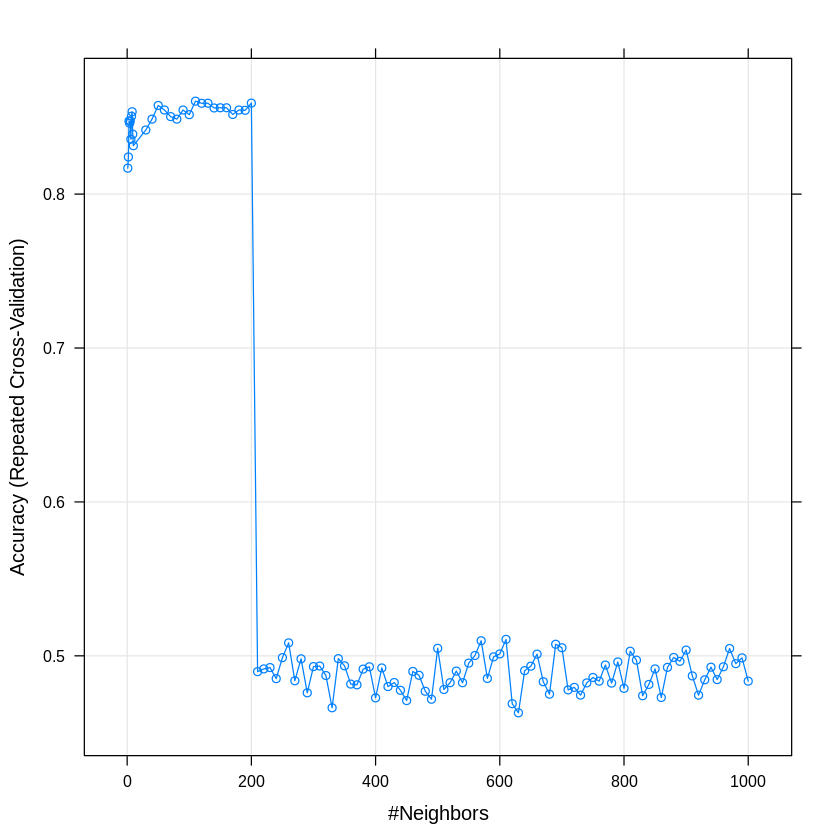

In [184]:
plot(model_knn_2)